# Projet 6 : Classifiez automatiquement des biens de consommation

# Problématique
La classification manuelle des produits selon leur catégorie est difficile et enclin à des erreurs.
# Objectif

L'objectif est ici de construire et d'analyser des graphiques de clustering afin d’en déduire ou pas, à l’aide des descriptions ou des images, la faisabilité de regrouper automatiquement des produits de même catégorie.
Il sera ensuite question de réaliser une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters.


# Source des données
Le dataset utilisé pour ce projet est "flipkart_com-ecommerce_sample_1050". Il contient des informations sur 1050 produits vendus sur Flipkart, un site de e-commerce en Inde.

## Bags of visual words

- **Prétraitement des images** 
- **SIF**
- **ORB**
- **CNN**
- **Réduction de dimension T-SNE**, 
- **Kmeans + ARI.**
- **Analyse graphique**



# Prétraitement Données Images

In [1]:
 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import pickle
import os
import time

# Traitement images
import PIL
from PIL import Image, ImageOps, ImageFilter
import cv2

from scipy.ndimage import gaussian_filter

import warnings
warnings.filterwarnings('ignore')

# Jeu de données


In [2]:
cleaned_df = pd.read_csv('cleaned_df.csv')

In [3]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               1050 non-null   int64 
 1   uniq_id                  1050 non-null   object
 2   image                    1050 non-null   object
 3   clean_product_name       1050 non-null   object
 4   clean_description        1050 non-null   object
 5   clean_categories         1050 non-null   object
 6   product_and_description  1050 non-null   object
dtypes: int64(1), object(6)
memory usage: 57.5+ KB


In [4]:
cleaned_df.drop(columns=['Unnamed: 0', 'uniq_id'], inplace=True)

In [5]:
cleaned_df = cleaned_df.rename(columns={'clean_product_name': 'product_name', 
                                        'clean_description': 'description', 
                                        'clean_categories': "category"})

cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   image                    1050 non-null   object
 1   product_name             1050 non-null   object
 2   description              1050 non-null   object
 3   category                 1050 non-null   object
 4   product_and_description  1050 non-null   object
dtypes: object(5)
memory usage: 41.1+ KB


In [6]:
image_df = cleaned_df[["image", "product_name", "description", "category"]].copy()


In [7]:
image_df.shape

(1050, 4)

In [8]:
image_df.head()

,image,product_name,description,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,elegance polyester multicolor abstract eyelet ...,key feature elegance polyester multicolor abst...,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,sathiyas cotton bath towel,specification sathiyas cotton bath towel 3 bat...,baby care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,eurospa cotton terry face towel set,key feature eurospa cotton terry face towel se...,baby care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,santosh royal fashion cotton printed king size...,key feature santosh royal fashion cotton print...,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,jaipur print cotton floral king sized double b...,key feature jaipur print cotton floral king si...,home furnishing


- ### Accès aux images

In [9]:
image_path = '/Users/danongohou/Desktop/P6/Images/'


- ### Liaison des images à leurs identifiants

In [10]:
image_df['stock_image'] = [image_path + row for row in image_df['image']]

- ### Dataset utile (image)

In [12]:
image_df = image_df[["image", 'stock_image', "product_name", "description", "category"]]
image_df.head()

,image,stock_image,product_name,description,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6/Images/55b85ea15a...,elegance polyester multicolor abstract eyelet ...,key feature elegance polyester multicolor abst...,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6/Images/7b72c92c2f...,sathiyas cotton bath towel,specification sathiyas cotton bath towel 3 bat...,baby care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6/Images/64d5d4a258...,eurospa cotton terry face towel set,key feature eurospa cotton terry face towel se...,baby care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6/Images/d4684dcdc7...,santosh royal fashion cotton printed king size...,key feature santosh royal fashion cotton print...,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6/Images/6325b6870c...,jaipur print cotton floral king sized double b...,key feature jaipur print cotton floral king si...,home furnishing


## EDA 

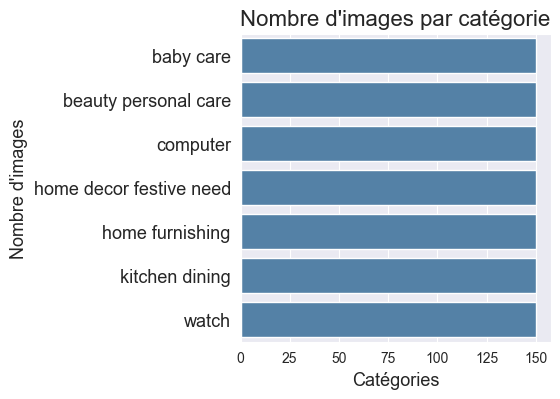

In [13]:
nb_image_categorie = image_df.groupby('category').agg({'image' : 'count'})

plt.figure(figsize=(4, 4))
sns.set_style('darkgrid')
sns.barplot(y=nb_image_categorie.index, x=nb_image_categorie.image,
            data=nb_image_categorie, color='SteelBlue')
plt.title('Nombre d\'images par catégorie', fontsize=16)
plt.xlabel('Catégories', fontsize=13)
plt.ylabel('Nombre d\'images', fontsize=13)
plt.yticks(fontsize=13)

plt.show()

- ### Voir quelques images

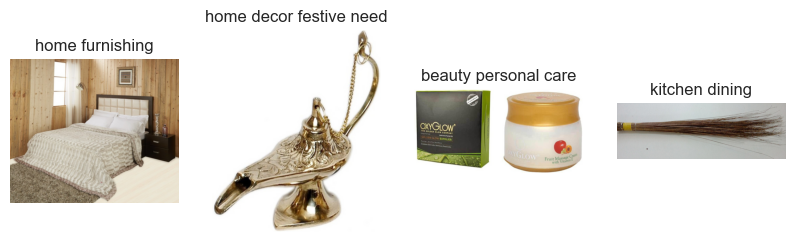

In [14]:
# Sélection de 4 images au hasard
import random

# Sélectionner 4 images aléatoires
random_images = random.sample(list(image_df.index), 4)

# Afficher les images
fig, axs = plt.subplots(1, 4, figsize=(10,10))
for i, idx in enumerate(random_images):
    img = plt.imread(image_df.loc[idx, 'stock_image'])
    category = image_df.loc[idx, 'category']
    axs[i].imshow(img)
    axs[i].set_title(category)
    axs[i].axis('off')
plt.show()


- ### Largeur des images

<Figure size 600x400 with 0 Axes>

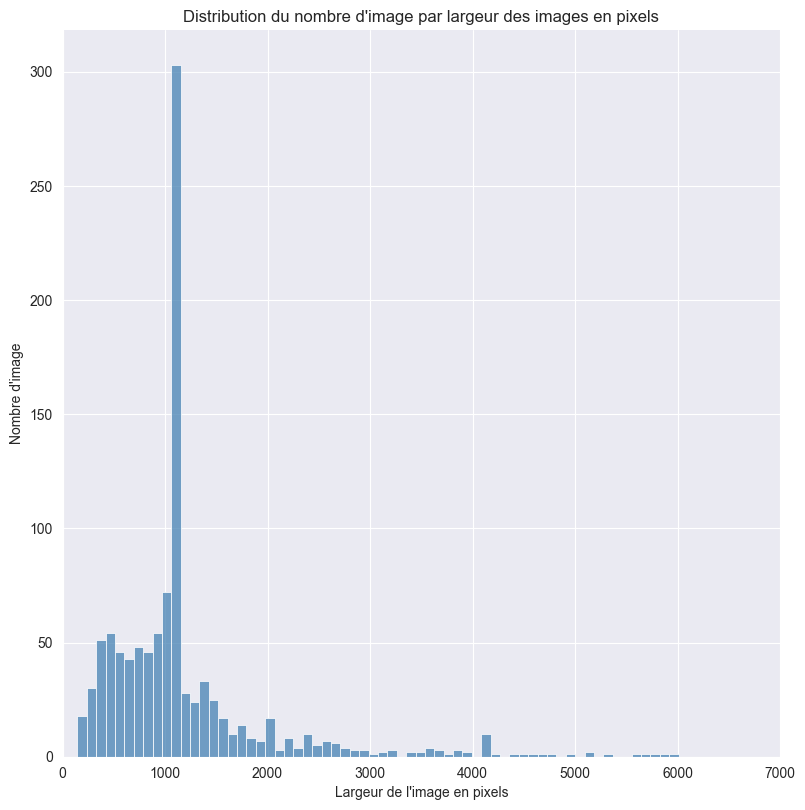

In [63]:
# Largeur des images
image_df['Largeur_img'] = [Image.open(row).size[0] for row in image_df['stock_image']]

plt.figure(figsize=(6, 4))
# Répartition du nombre d'images par taille de l'image en pixel
sns.displot(image_df['Largeur_img'], color='SteelBlue', height=8)
plt.title('Distribution du nombre d\'image par largeur des images en pixels')
plt.xlim(0, 7000)
plt.xlabel('Largeur de l\'image en pixels')
plt.ylabel('Nombre d\'image')
plt.show()

- ### Hauteur des images

<Figure size 400x400 with 0 Axes>

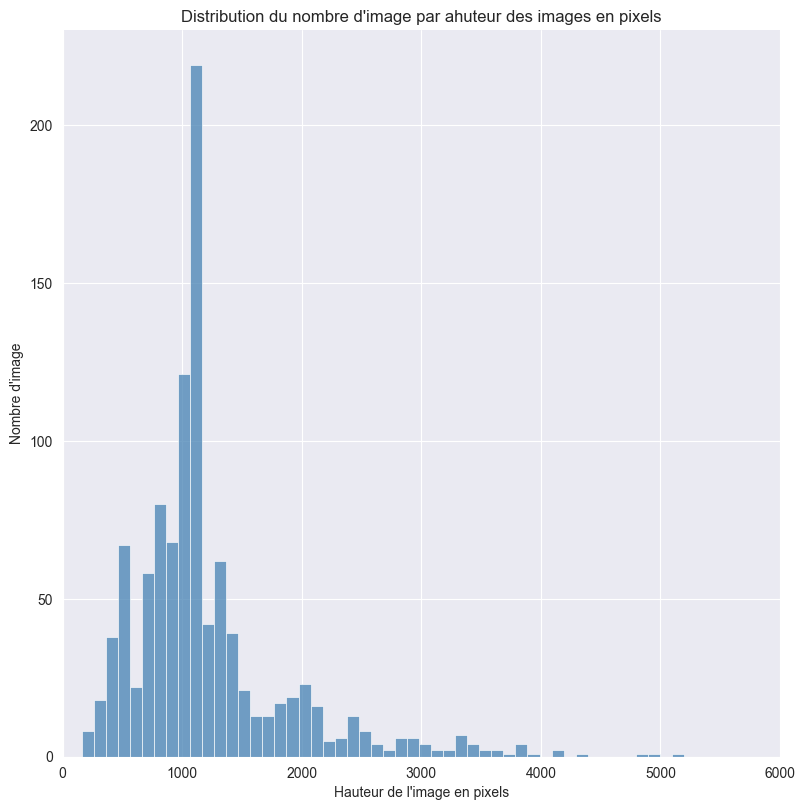

In [64]:
# Hauteur des images
image_df['Hauteur_img'] = [Image.open(row).size[1] for row in image_df['stock_image']]

# Répartition du nombre d'images par taille de l'image en pixel
sns.displot(image_df['Hauteur_img'], color='SteelBlue', height=8)
plt.title('Distribution du nombre d\'image par ahuteur des images en pixels')
plt.xlim(0, 6000)
plt.xlabel('Hauteur de l\'image en pixels')
plt.ylabel('Nombre d\'image')
plt.show()

- ### Taille des images

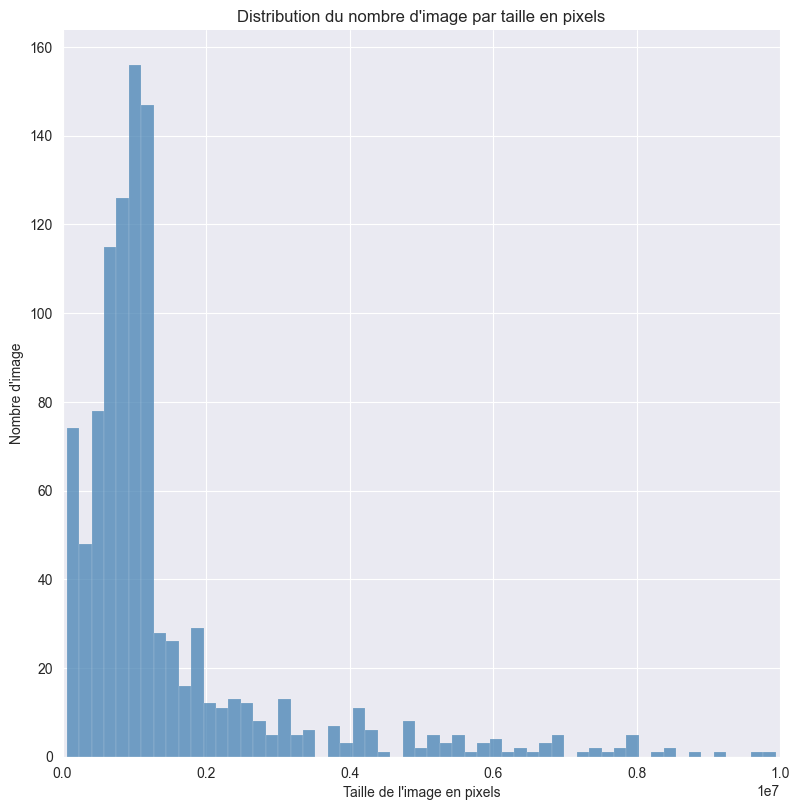

In [15]:
# Taille des images
image_df['Taille_img'] = [(Image.open(row).size[0] * Image.open(row).size[1])
                      for row in image_df['stock_image']]

# Répartition du nombre d'images par taille de l'image en pixel
sns.displot(image_df['Taille_img'], color='SteelBlue', height=8)
plt.title('Distribution du nombre d\'image par taille en pixels')
plt.xlim(0, 10000000)
plt.xlabel('Taille de l\'image en pixels')
plt.ylabel('Nombre d\'image')
plt.show()



## Prétraitement des images

In [23]:
import cv2
import numpy as np
import os

# Spécifier le chemin d'accès au répertoire contenant les images
image_path = '/Users/danongohou/Desktop/P6/Images/'
image_df['stock_image'] = [image_path + row for row in image_df['image']]

for i, img in enumerate(image_df['stock_image']):
    
    # Joindre le chemin d'accès au répertoire avec le nom de fichier de l'image
    img_path = os.path.join(image_path, img)
    
    # Charger l'image
    img = cv2.imread(img_path)
    
    # Conversion en niveau de gris
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Réduction de bruit avec le filtre GaussianBlur
    img = cv2.GaussianBlur(img, (3, 3), 0)
    
    # Correction du contraste avec égalisation d'histogramme
    img = cv2.equalizeHist(img)
    
    # Réduction de dimension avec OpenCV
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    
    # Ajouter l'image traitée au DataFrame
    image_df.at[i, 'stock_image'] = img



In [25]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image         1050 non-null   object
 1   stock_image   1050 non-null   object
 2   product_name  1050 non-null   object
 3   description   1050 non-null   object
 4   category      1050 non-null   object
 5   Taille_img    1050 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 49.3+ KB
